In [1]:
import torch 

import metal.mmtl.dataset as dataset
import numpy as np
import pandas as pd

from metal.mmtl.bert_tasks import create_tasks
from metal.mmtl.metal_model import MetalModel
from metal.mmtl.scorer import Scorer
from metal.utils import convert_labels
from pytorch_pretrained_bert import BertTokenizer

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


### Load Model and Data

In [2]:
model_path = '/dfs/scratch0/jdunnmon/mmtl/sota_quest/debugging/COLA/COLA_19_48_08/best_model.pth'
csv_path = "/".join(model_path.split('/')[0:-2]) #set to -1 if permissions exist
task_name = model_path.split('/')[-3]

bert_model = 'bert-base-uncased'
max_len = 256
bert_output_dim = 768
dl_kwargs = {"batch_size": 32, 'shuffle': False}

In [3]:
#Get DataLoader
dataset_cls = getattr(dataset, task_name.upper() + "Dataset")
dev_ds = dataset_cls(
    split="dev",
    bert_model=bert_model,
    max_len=max_len,
    max_datapoints=-1,
)
dev_dl = dev_ds.get_dataloader(**dl_kwargs)

#Load best model for specified task
tasks = create_tasks(
        task_names=[task_name],
        bert_model=bert_model,
        split_prop=0.8,
        max_len=max_len,
        dl_kwargs={"batch_size": 1},
        bert_output_dim=bert_output_dim,
        max_datapoints=10,
    )

model = MetalModel(tasks, verbose=False, device=-1)
model.load_state_dict(torch.load(model_path)['model'])

Loading BERT model...



Loading COLA Dataset
Loading BERT model...



Loading BERT model...


### Generate DataFrame of Predictions and True Labels

In [4]:
data = {
    'sentence1': [],
    'sentence2': [],
    'label': [],
    'score' : []
}
max_batches = 100
tokenizer = BertTokenizer.from_pretrained(bert_model, do_lower_case=True)
from tqdm import tqdm
count = 0
for x, y in tqdm(list(dev_dl)):
    for tokens_idx in x[0]:
        tokens = tokenizer.convert_ids_to_tokens(tokens_idx.numpy())
        phrases = ' '.join(tokens).replace('[PAD]', '').replace('[CLS]', '').split('[SEP]')
        data['sentence1'] += [phrases[0]]
        if len(phrases) > 1:
            data['sentence2'] += [phrases[1]] 
        else:
            data['sentence2'] += ['NA']
    scores = model.calculate_output(x, [task_name])[task_name].detach().cpu().numpy()[:, 0] # .flatten()
    data['score'] += list(scores)
    data['label'] += list(convert_labels(y, 'categorical', 'onezero').numpy())
    count += 1
    if count > max_batches:
        break
        

df_error = pd.DataFrame(data, columns=['sentence1', 'sentence2', 'score', 'label'])
df_error['pred'] = 1* (df_error.score > 0.5)
df_error['is_wrong'] = df_error['pred'] != df_error['label']

100%|██████████| 33/33 [00:01<00:00, 33.00it/s]


### Saving and Loading Error DataFrame

In [5]:
def save_dataframe(df,filepath):
    df.to_csv(filepath, sep='\t')
    print('Saved dataframe to: ', filepath)
    
def load_dataframe(filepath):
    df = pd.read_csv(filepath, sep='\t')
    return df

filepath = f'{csv_path}/dev_error_analysis.tsv'
save_dataframe(df_error,filepath)
df_error = load_dataframe(filepath)
df_error.head()

Saved dataframe to:  /dfs/scratch0/jdunnmon/mmtl/sota_quest/debugging/COLA/dev_error_analysis.tsv


,Unnamed: 0,sentence1,sentence2,score,label,pred,is_wrong
0,0,the sailors rode the breeze clear of the rock...,,0.987432,1,1,False
1,1,the weights made the rope stretch over the pu...,,0.992936,1,1,False
2,2,the mechanical doll wr ##ig ##gled itself loo...,,0.226052,1,0,True
3,3,"if you had eaten more , you would want less .",,0.988117,1,1,False
4,4,"as you eat the most , you want the least .",,0.131787,0,0,False


### Looking at Random Examples

In [6]:
def print_random_pred(df):
    row = df.iloc[np.random.randint(df.shape[0])]
    print(f'sentence1: \t{row.sentence1}')
    print(f'sentence2: \t{row.sentence2}')
    print('score: \t{:.4f}'.format(row.score))    
    print(f'label: \t{row.label}')   

In [7]:
print("\033[1mINCORRECT PREDICTIONS\033[0;0m")
for i in range(3):
    print_random_pred(df_error[df_error.is_wrong==True])
    print()
    
print("\033[1mCORRECT PREDICTIONS\033[0;0m")
for i in range(3):
    print_random_pred(df_error[df_error.is_wrong==False])
    print()

INCORRECT PREDICTIONS
sentence1: 	 john was tall , but i don ' t know on what occasions . 
sentence2: 	      
score: 	0.9735
label: 	0

sentence1: 	 john and someone were dancing together , but i don ' t know who . 
sentence2: 	                  
score: 	0.9914
label: 	0

sentence1: 	 chocolate eggs were hidden from each other by the children . 
sentence2: 	   
score: 	0.9957
label: 	0

CORRECT PREDICTIONS
sentence1: 	 i know which book jose didn ' t read for class , and which book lilly did it for him . 
sentence2: 	nan
score: 	0.3956
label: 	0

sentence1: 	 mike talked about politics yesterday to my friends . 
sentence2: 	                  
score: 	0.9911
label: 	1

sentence1: 	 i know the person whose mother died . 
sentence2: 	                       
score: 	0.9920
label: 	1



## Sandbox for Error Analysis

**1. We want to look at examples that are "barely" wrong and "barely" right since we have hope for boosts here.**

In [8]:
def print_barely_wrong_pred(df,thresh=0.05):
    df_temp = df[df.is_wrong==True]
    idx = np.where(np.abs(df_temp.score - 0.5) <= thresh)[0]
    row = df_temp.iloc[np.random.choice(list(idx))]
    
    print(f'sentence1: \t{row.sentence1}')
    print(f'sentence2: \t{row.sentence2}')
    print('score: \t{:.4f}'.format(row.score))    
    print(f'label: \t{row.label}')  
    
def print_barely_right_pred(df,thresh=0.05):
    df_temp = df[df.is_wrong==False]
    idx = np.where(np.abs(df_temp.score - 0.5) <= thresh)[0]
    row = df_temp.iloc[np.random.choice(list(idx))]
    
    print(f'sentence1: \t{row.sentence1}')
    print(f'sentence2: \t{row.sentence2}')
    print('score: \t{:.4f}'.format(row.score))    
    print(f'label: \t{row.label}')   

In [9]:
print("\033[1mBARELY WRONG\033[0;0m")
for i in range(3):
    print_barely_wrong_pred(df_error)
    print()
    
print("\033[1mBARELY RIGHT\033[0;0m")
for i in range(3):
    print_barely_right_pred(df_error)
    print()

BARELY WRONG
sentence1: 	 where did you go and who ate what ? 
sentence2: 	                  
score: 	0.4711
label: 	1

sentence1: 	 was sunk . 
sentence2: 	            
score: 	0.5241
label: 	0

sentence1: 	 med ##ea denied poisoning the phoenix . 
sentence2: 	       
score: 	0.4856
label: 	1

BARELY RIGHT
sentence1: 	 who is she trying to make up to now ? 
sentence2: 	                 
score: 	0.5353
label: 	1

sentence1: 	 who is she trying to make up to now ? 
sentence2: 	                 
score: 	0.5353
label: 	1

sentence1: 	 who is she trying to make up to now ? 
sentence2: 	                 
score: 	0.5353
label: 	1



**2. We also want to look at examples we got completely wrong since that could point to a systematic bias in the data/model. It could also help us find examples in the dataset that are mislabeled by human annotators**

In [10]:
def print_very_wrong_pred(df,thresh=0.95):
    df_temp = df[df.is_wrong==True]
    idx = np.where(np.abs(df_temp.score - df_temp.label) >= thresh)[0]
    row = df_temp.iloc[np.random.choice(list(idx))]
    
    print(f'sentence1: \t{row.sentence1}')
    print(f'sentence2: \t{row.sentence2}')
    print('score: \t{:.4f}'.format(row.score))    
    print(f'label: \t{row.label}') 

In [11]:
print("\033[1mVERY WRONG\033[0;0m")
for i in range(3):
    print_very_wrong_pred(df_error)
    print()

VERY WRONG
sentence1: 	 john and someone were dancing together , but i don ' t know who . 
sentence2: 	                  
score: 	0.9914
label: 	0

sentence1: 	 the paper was written by john up . 
sentence2: 	      
score: 	0.9642
label: 	0

sentence1: 	 we gave us presents . 
sentence2: 	          
score: 	0.9950
label: 	0



**3. To find systematic errors, we can also look for correlations between certain features and the incorrectness a la Socratic**


We can make this way more sophisticated by perhaps using embeddings instead of this simple [BoW featurization](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer).

In [12]:
#Create a vector of correct/incorrect predictions
y = 2*(np.array(df_error.is_wrong.astype(float))-0.5)

#Create BoW featurization
from sklearn.feature_extraction.text import CountVectorizer
corpus = np.array(list(df_error.sentence1))
vectorizer = CountVectorizer(ngram_range=(2,5), stop_words='english')
X = vectorizer.fit_transform(corpus)

#Run LR to find correlations
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(penalty="l1")
lr_model.fit(X, y)

/dfs/scratch0/vschen/venv-mmtl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

ega tion
john believes
john bought
john eat
don know


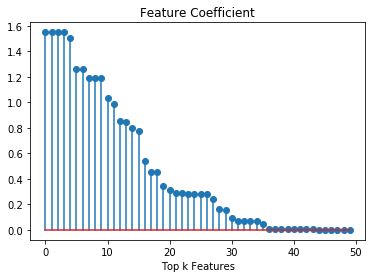

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.stem(np.sort(np.abs(lr_model.coef_)[0])[::-1][0:50])
plt.title('Feature Coefficient')
plt.xlabel('Top k Features')

top_idx = np.argsort(np.abs(lr_model.coef_)[0])[::-1][0:50]
names = vectorizer.get_feature_names()
for i in range(5):
    print (names[top_idx[i]])

In [14]:
print("\033[1mSYSTEMATIC EXAMPLES\033[0;0m")
for i in range(5):
    idx = list(np.where(X.todense()[:,top_idx[i]] == 1)[0])
    for ii in range(len(idx)):
        df_temp = df_error
        row = df_temp.iloc[idx[ii]]

        print(f'sentence1: \t{row.sentence1}')
        print(f'sentence2: \t{row.sentence2}')
        print('score: \t{:.4f}'.format(row.score))    
        print(f'label: \t{row.label}')
        print()

SYSTEMATIC EXAMPLES
sentence1: 	 the defendant deny the all ##ega ##tion . 
sentence2: 	            
score: 	0.9753
label: 	0

sentence1: 	 the defendants denies the all ##ega ##tion . 
sentence2: 	            
score: 	0.9711
label: 	0

sentence1: 	 john believes it that bill is here . 
sentence2: 	         
score: 	0.5245
label: 	0

sentence1: 	 john believes it sincerely that bill is here . 
sentence2: 	        
score: 	0.9850
label: 	0

sentence1: 	 john bought a book on the table . 
sentence2: 	       
score: 	0.0600
label: 	1

sentence1: 	 john bought a dog for himself to play with . 
sentence2: 	 
score: 	0.9941
label: 	0

sentence1: 	 i demand that the more john eat , the more he pays . 
sentence2: 	    
score: 	0.8997
label: 	0

sentence1: 	 agnes wondered how john could eat but it ' s not clear what . 
sentence2: 	                   
score: 	0.9099
label: 	0

sentence1: 	 i don ' t know if i should agree . 
sentence2: 	     
score: 	0.9927
label: 	1

sentence1: 	 john ate dinn